In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/sample_submission.csv
/kaggle/input/allstate-claims-severity/test.csv


# Load Data

In [2]:
train=pd.read_csv('/kaggle/input/allstate-claims-severity/train.csv', index_col='id')
test=pd.read_csv('/kaggle/input/allstate-claims-severity/test.csv', index_col='id')
submission=pd.read_csv('/kaggle/input/allstate-claims-severity/sample_submission.csv', index_col='id')
print(train.shape, test.shape, submission.shape)

(188318, 131) (125546, 130) (125546, 1)


# Target Variable

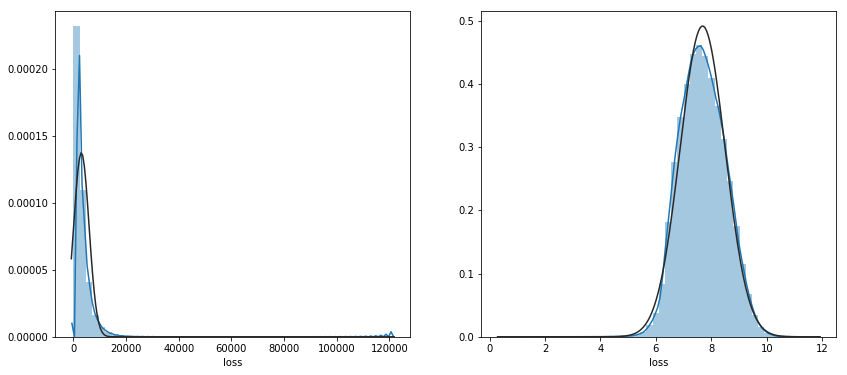

In [3]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(train['loss'], fit=norm, ax=ax1)
sns.distplot(np.log(train['loss']+1), fit=norm, ax=ax2)

In [4]:
train=train.drop(train.loc[train['loss']>40000].index)

In [5]:
train['loss']=np.log(train['loss']+1)
Ytrain=train['loss']

In [6]:
data=train
train=train[list(test)]
all_data=pd.concat((train, test))
all_data.shape

(313841, 130)

# Preprocessing

In [7]:
cat_features=list(np.where(all_data.dtypes==np.object)[0])
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]


In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
non_numeric=list(all_data.select_dtypes(np.object))
for cols in non_numeric:
    le.fit(all_data[cols])
    all_data[cols]=le.transform(all_data[cols])

In [9]:
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Ytrain.shape, Xtest.shape, submission.shape)

(188295, 130) (125546, 130)
(188295, 130) (188295,) (125546, 130) (125546, 1)


# Build Models

In [10]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#import optuna
from sklearn.model_selection import cross_val_score

## XGBoost

In [11]:
model_xgb=XGBRegressor(tree_method='gpu_hist', seed=18, objective='reg:linear', n_jobs=-1, verbosity=0,
                       colsample_bylevel=0.764115402027029, colsample_bynode=0.29243734009596956, 
                       colsample_bytree= 0.7095719673041723, gamma= 4.127534050725986, learning_rate= 0.02387231810322894, 
                       max_depth=14, min_child_weight=135, n_estimators=828,reg_alpha=0.3170105723222332, 
                       reg_lambda= 0.3660379465131937, subsample=0.611471430211575)
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.764115402027029,
             colsample_bynode=0.29243734009596956,
             colsample_bytree=0.7095719673041723, gamma=4.127534050725986,
             importance_type='gain', learning_rate=0.02387231810322894,
             max_delta_step=0, max_depth=14, min_child_weight=135, missing=None,
             n_estimators=828, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.3170105723222332,
             reg_lambda=0.3660379465131937, scale_pos_weight=1, seed=18,
             silent=None, subsample=0.611471430211575, tree_method='gpu_hist',
             verbosity=0)

## LightGBM

In [12]:
model_LGB=LGBMRegressor(objective='regression_l1', random_state=18, subsample_freq=1,
                        colsample_bytree=0.3261853512759363, min_child_samples=221, n_estimators=2151, num_leaves= 45, 
                        reg_alpha=0.9113713668943361, reg_lambda=0.8220990333713991, subsample=0.49969995651550947, 
                        max_bin=202, learning_rate=0.02959820893211799) #,device='gpu')
model_LGB

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.3261853512759363, importance_type='split',
              learning_rate=0.02959820893211799, max_bin=202, max_depth=-1,
              min_child_samples=221, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2151, n_jobs=-1, num_leaves=45,
              objective='regression_l1', random_state=18,
              reg_alpha=0.9113713668943361, reg_lambda=0.8220990333713991,
              silent=True, subsample=0.49969995651550947,
              subsample_for_bin=200000, subsample_freq=1)

## CatBoost

In [13]:
model_Cat=CatBoostRegressor(loss_function='MAE', random_seed=18, task_type='GPU', cat_features=cat_features, verbose=False,
                            iterations=2681, learning_rate=0.2127106032536721, depth=7, l2_leaf_reg=5.266150673910493, 
                            random_strength=7.3001140226199315, bagging_temperature=0.26098669708900213)
model_Cat

# Final Fit & Predict

In [14]:
model_Cat.fit(Xtrain, Ytrain)
model_LGB.fit(Xtrain, Ytrain)
model_xgb.fit(Xtrain, Ytrain)

lgb_predictions=model_LGB.predict(Xtest)
cat_predictions=model_Cat.predict(Xtest)
xgb_predictions=model_xgb.predict(Xtest)

In [15]:
predictions=(lgb_predictions + cat_predictions + xgb_predictions)/3

predictions=np.exp(predictions)-1
submission['loss']=predictions
submission.to_csv('Result.csv')
submission.head()

,loss
id,
4,1465.630531
6,1884.423793
9,9439.052114
12,6357.400376
15,785.763916
